Visualize learned TRF coefficients.

In [1]:
from argparse import ArgumentParser, Namespace
from collections import defaultdict
from copy import deepcopy
import io
from itertools import product
from pathlib import Path
import pickle
import sys

from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.base import clone
import torch
from tqdm.auto import tqdm, trange

In [2]:
import logging
L = logging.getLogger(__name__)

In [3]:
from IPython.display import HTML

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
sys.path.append(str(Path(".").resolve().parent.parent))
from berp.datasets import BerpDataset, NestedBerpDataset
from berp.datasets.eeg import load_eeg_dataset
import berp.models.reindexing_regression as rr
from berp.viz.trf import trf_to_dataframe, plot_trf_coefficients
from berp.viz.trf_em import pipeline_to_dataframe

In [6]:
workflow = "heilbron2022"
model = "EleutherAI/gpt-neo-2.7B/n10000"
# model = "gpt2/n10000"
# model = "distilgpt2/n1000"

trf_run_name = "trf-berp-cannon_3quantiles.29720801"
# trf_run_name = "trf_t1"
# trf_run_name = "trf-berp-fixed.20230124"
# trf_run_name = "trf-berp-cannon.20221215.3quant"

subjects = list(range(1, 20))  # [14, 15, 16, 17, 18, 19]
runs = list(range(1, 20))
stories = ["old-man-and-the-sea"]

target_sensors = ["B19", "B20", "B22"]

# Match dataset spec.
normalize_X_ts = False
normalize_X_variable = True
normalize_Y = False

n_evaluation_folds = 4

In [7]:
all_run_names = [trf_run_name]
model_dirs = [f"../../workflow/{workflow}/results_wide/{model}/{run_name}"
              for run_name in all_run_names]
dataset_dir = f"../../workflow/{workflow}/data/dataset/{model}"
stimulus_dir = f"../../workflow/{workflow}/data/stimulus/{model}"

## Load results

In [8]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)

In [9]:
# Load pipelines.
if len(model_dirs) > 1:
    raise NotImplementedError("not yet supporting multiple pipelines")

pipes = []
for run in tqdm(model_dirs):
    pipeline_path = Path(run) / "params" / "pipeline.pkl"
    if not pipeline_path.exists():
        L.warn(f"Missing pipeline at {pipeline_path}")
        
    with pipeline_path.open("rb") as f:
        pipes.append(CPU_Unpickler(f).load())
        
pipe = pipes[0]

  0%|          | 0/1 [00:00<?, ?it/s]

## Preprocessing

In [10]:
coef_df = pipeline_to_dataframe(pipe)

In [11]:
coef_df

,predictor,lag,sensor,coef,epoch_time,predictor_name,sensor_name
subject,,,,,,,
1,0,0,0,3.268718e-04,0.0000,all_phons_pitch,B22
1,0,0,1,7.158992e-05,0.0000,all_phons_pitch,D19
1,0,0,2,-6.300032e-07,0.0000,all_phons_pitch,A19
1,0,0,3,-9.930664e-05,0.0000,all_phons_pitch,C22
1,0,0,4,7.467340e-05,0.0000,all_phons_pitch,C10
...,...,...,...,...,...,...,...
19,15,72,3,2.394118e-04,0.5625,var_word_surprisal,C22
19,15,72,4,-1.045691e-04,0.5625,var_word_surprisal,C10
19,15,72,5,-2.450826e-05,0.5625,var_word_surprisal,C32


In [12]:
coef_df.predictor_name.unique()

array(['all_phons_pitch', 'all_phons_env_var', 'all_phons_sg1',
       'all_phons_sg2', 'all_phons_sg3', 'all_phons_sg4', 'all_phons_sg5',
       'all_phons_sg6', 'all_phons_sg7', 'all_phons_sg8',
       'all_phons_surprisals', 'word_onset', 'phoneme_onset',
       'var_recognition_onset', 'var_word_frequency',
       'var_word_surprisal'], dtype=object)

### Recognition-locked responses

In [13]:
sns.set("talk")

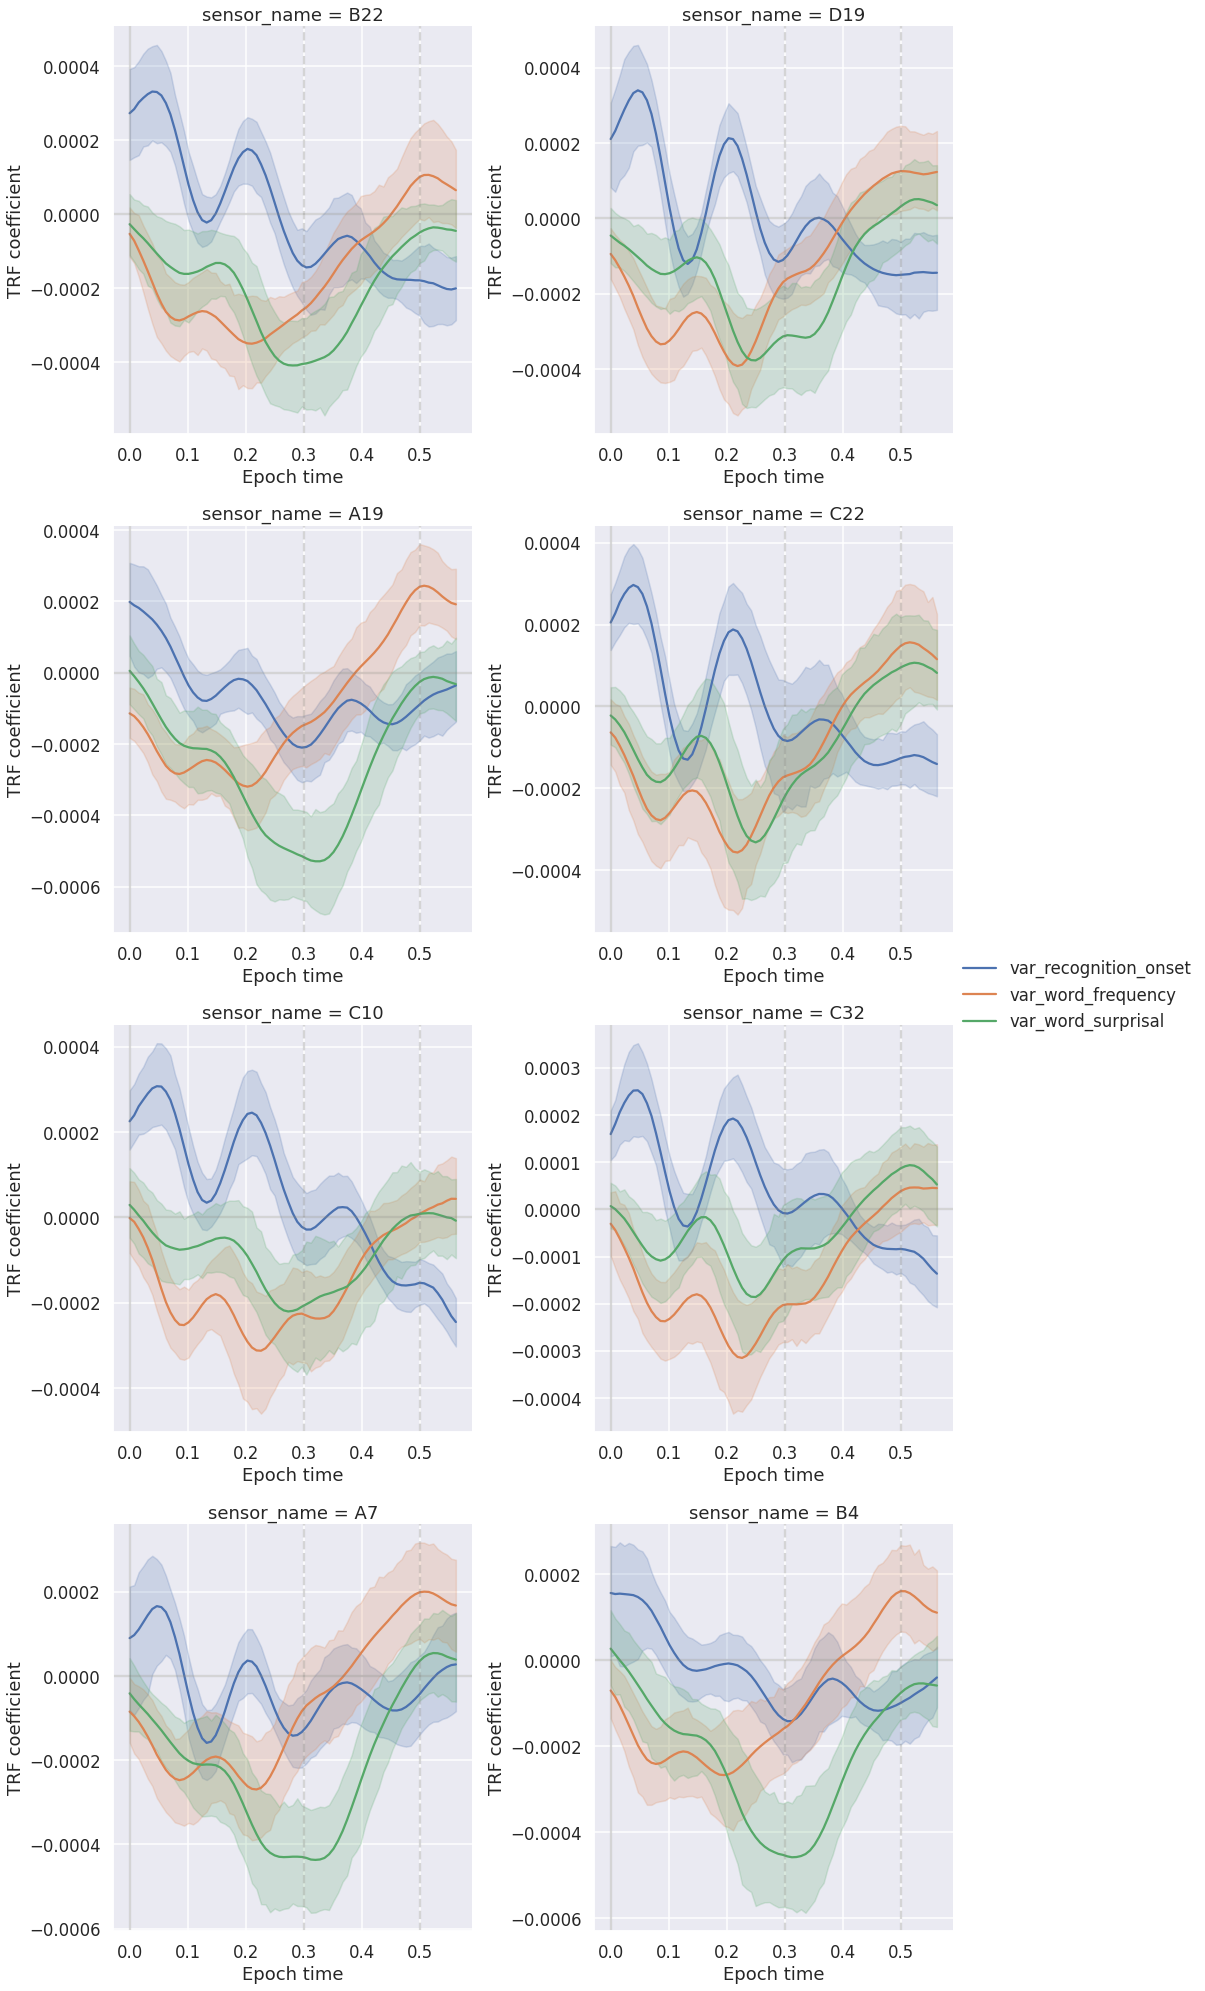

In [14]:
def plot_variable(data, **kwargs):
    plot_trf_coefficients(data, predictor_match_patterns=["var_"], errorbar=("ci", 95))

g = sns.FacetGrid(data=coef_df, col="sensor_name", col_wrap=2, height=7,
                  sharex=False, sharey=False)
g.map_dataframe(plot_variable)
g.add_legend()

#### Surprisal

<AxesSubplot:xlabel='epoch_time', ylabel='coef'>

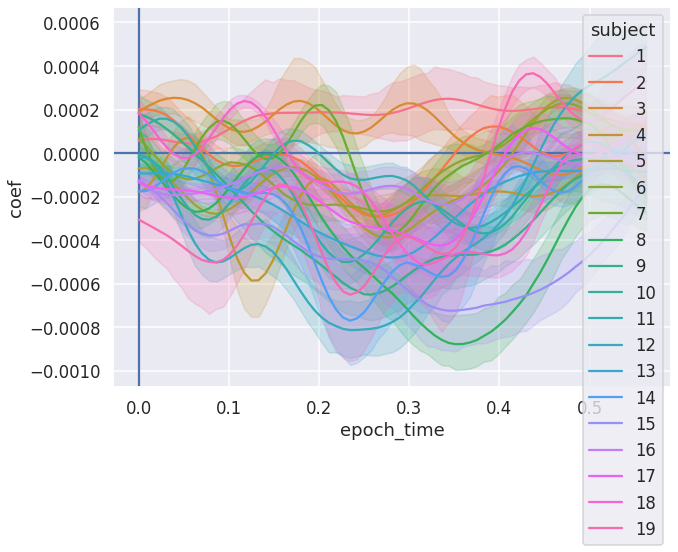

In [15]:
plt.subplots(figsize=(10, 7))
plt.axvline(0); plt.axhline(0)
sns.lineplot(data=coef_df[(coef_df.predictor_name == "var_word_surprisal")].reset_index(),
             x="epoch_time", y="coef", hue="subject")

#### Word onset

In [16]:
# mod_coef_df = coef_df[coef_df.predictor_name.isin(["var_word_frequency", "var_word_surprisal"])] \
#     .copy().reset_index().set_index(["predictor_name", "subject", "sensor", "lag", "epoch_time"])
# results = mod_coef_df.loc["var_word_frequency"] + mod_coef_df.loc["var_word_surprisal"]

# plt.figure(figsize=(10, 7))
# plt.axvline(0); plt.axhline(0)
# sns.lineplot(data=results.reset_index(), x="epoch_time", y="coef", hue="subject")

In [17]:
# plt.figure(figsize=(10, 7))
# plt.axvline(0); plt.axhline(0)
# sns.lineplot(data=results.reset_index(), x="epoch_time", y="coef")

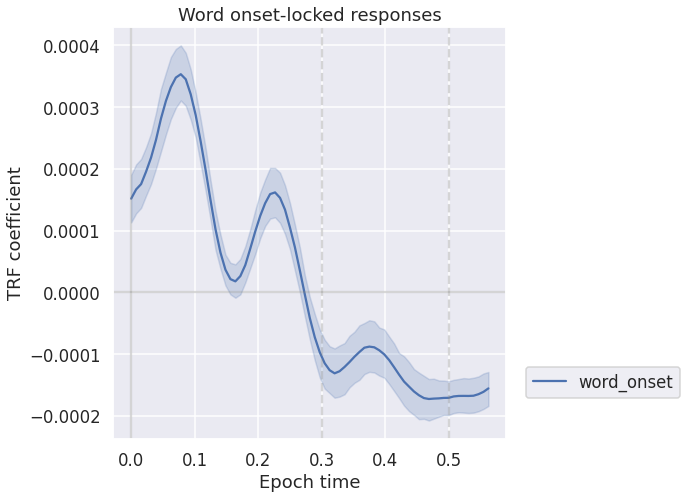

In [18]:
sns.set("talk")
plt.figure(figsize=(10, 7))
plot_trf_coefficients(coef_df, predictor_match_patterns=["word_onset"])
plt.title("Word onset-locked responses")
None

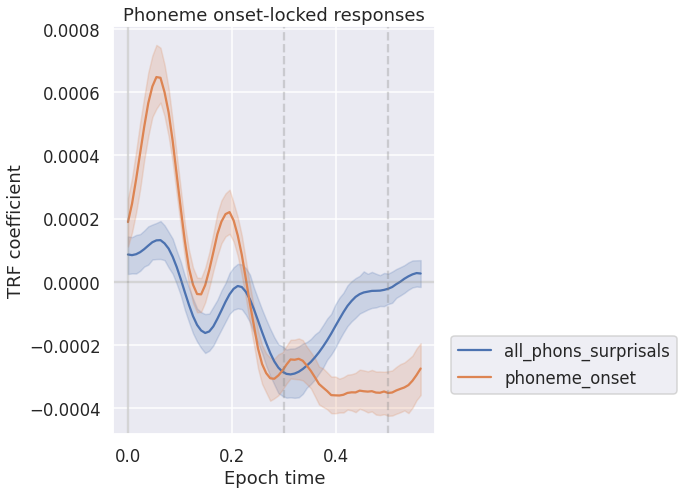

In [19]:
sns.set("talk")
plt.figure(figsize=(10, 7))
plot_trf_coefficients(coef_df, predictor_match_patterns=["phoneme_onset", "all_phons_surprisals"])
plt.title("Phoneme onset-locked responses")
None